<a href="https://colab.research.google.com/github/enya-yx/LangChain-Courses/blob/main/langgraph_intro_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install "langchain-google-genai" "langchain" "langchain-core" "langgraph-prebuilt" "google-generativeai" "langchain_community" "docarray" "langchain_experimental"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.3/53.3 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.1/489.1 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.8/302.8 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.1/210.1 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.6/426.6 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.3/233.3 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 2.4 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.4
    Uninstalling requests-2.32.4:
      Success

In [4]:
import google.generativeai as genai
import os
from google.colab import userdata

os.environ["GOOGLE_API_KEY"] = userdata.get('google_api_key')
os.environ["TAVILY_API_KEY"] = userdata.get('tavily_api_key')

# Configure the generative AI library with your API key
genai.configure(api_key=os.environ["GOOGLE_API_KEY"])


In [5]:
from langchain_google_genai import ChatGoogleGenerativeAI
#from langchain.prompts import PromptTemplate, ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

# Define llm
llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=0,
    verbose=True
)


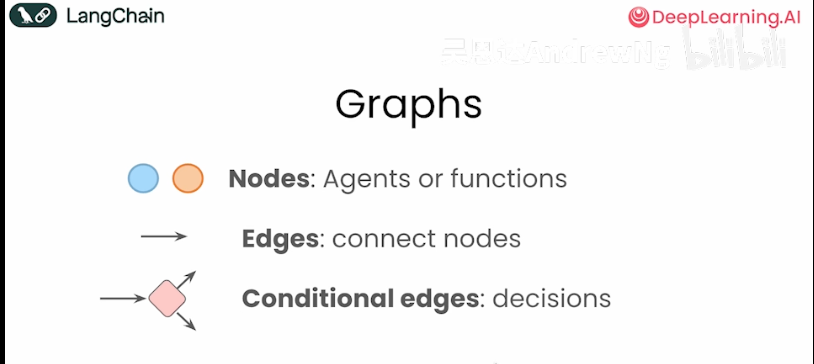

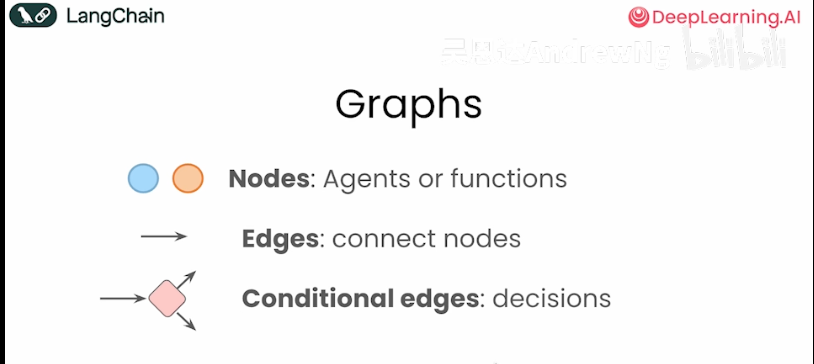

In [6]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ToolMessage
from langchain_community.tools.tavily_search import TavilySearchResults

# Define a Simple Agent State;
# Agent State is accessible to all parts of the graph.
class AgentState(TypedDict):
  messages: Annotated[list[AnyMessage], operator.add]

In [7]:
tool = TavilySearchResults(max_results=2)
print(tool.name)

tavily_search_results_json


/tmp/ipython-input-983460408.py:1: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tool = TavilySearchResults(max_results=2)


In [8]:
# Define a simple agent
class Agent:
  def __init__(self, model, tools ,system=""):
    self.system = system
    graph = StateGraph(AgentState)
    graph.add_node("llm",self.call_llm)
    graph.add_node("action", self.take_action)
    graph.add_conditional_edges(
        "llm",
        self.exists_action,
        {True: "action", False: END}
    )
    graph.add_edge("action", "llm")
    graph.set_entry_point("llm")
    self.graph = graph.compile()
    self.tools = {t.name: t for t in tools}
    self.model = model.bind_tools(tools)

  def exists_action(self, state: AgentState):
    result = state['messages'][-1]
    return len(result.tool_calls) > 0

  def call_llm(self, state: AgentState):
    messages = state["messages"]
    if self.system:
      messages = [SystemMessage(content=self.system)] + messages
    message = self.model.invoke(messages)
    next_tools = message.tool_calls if message.tool_calls else ["END"]
    print(f"Next tools: {next_tools}")
    return {'messages': [message]}

  def take_action(self, state: AgentState):
    tool_calls = state['messages'][-1].tool_calls
    results = []
    for t in tool_calls:
      print(f"Calling function: {t}")
      result = self.tools[t['name']].invoke(t['args'])
      print(f"Result from calling function: ", result)
      results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
    print("Back to the model")
    return {'messages': results}

In [9]:
prompt = """You are a smart research assistant. Use the search engine to query results. \
You are allowed to make multiple calls (either together or in sequence).\
Only look up information when you are sure of what you want. \
"""
abot = Agent(llm, [tool], system=prompt)

In [11]:
messages = [HumanMessage(content = "What is the weather in Ann Arbor, MI")]
result = abot.graph.invoke({"messages": messages})

Next tools: [{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Ann Arbor, MI'}, 'id': '4c2d0cec-7ce2-4932-b63c-4a8d1b66deb2', 'type': 'tool_call'}]
Calling function: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in Ann Arbor, MI'}, 'id': '4c2d0cec-7ce2-4932-b63c-4a8d1b66deb2', 'type': 'tool_call'}
Result from calling function:  [{'title': 'Ann Arbor, MI Monthly Weather - AccuWeather', 'url': 'https://www.accuweather.com/en/us/ann-arbor/48104/may-weather/329380', 'content': '# Ann Arbor, MI\n\nAnn Arbor\n\nMichigan\n\n## Around the Globe\n\nAround the Globe\n\n### Hurricane Tracker\n\n### Severe Weather\n\n### Radar & Maps\n\n### News & Features\n\n### Astronomy\n\n### Business\n\n### Climate\n\n### Health\n\n### Recreation\n\n### Sports\n\n### Travel\n\n### Warnings\n\n### Data Suite\n\n### Forensics\n\n### Advertising\n\n### Superior Accuracy™\n\n### Video\n\n### Winter Center\n\n## Monthly\n\n## May\n\n## 2026\n\n## Daily\n\n## Temperature Graph

In [12]:
result["messages"][-1]

AIMessage(content=[{'type': 'text', 'text': 'The current weather in Ann Arbor, MI as of 3:03 AM on Monday, Jan 5 is mainly cloudy with a high of 37° today, and overcast with areas of freezing fog late tonight, with a low of 28°.', 'extras': {'signature': 'CtYCAXLI2nwQezyBJiqZzg63pK207dP0E1J25K13G1ocF+O0egJn/TE+N4l8osZfrq3ysMzqEP0PT/LiPkqmPo0N4p0qCPnRgDNqIvZd9b7ED+VOORpEeghjYa9cqg+lEozngG0OnWiIX7cqP+qchr+6Eu/LQvxqgDGEi9M6R6FB/aCaSvIPYjTFUaMrbtgxHwwk2O8m+bmXXImR06Uw1FuY31HD3Q7cuMojO6yoOQrSusj01U9XnSxdz5iPcGw1yO4jvXBAZVf01i9No6GveimvBb4vrGPHwpsAhgUqcw9UtrfSLT3cbik6USKjOxmA/UrzsVEl3RFFsWAoo0k3di0ZMmzAqTKaMVrKTHvu5ufwQiBRha3bT3DcT5MTc4OJgLwO00ndeCqQAO1ofFIjw3vaudDZ1PbWo1tP/bhAh2gb9HdstPBAfnkc83uPoxaZskMnYPxB2NSs'}}], additional_kwargs={}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--019b8d2f-2610-7e40-b290-efe3be998746-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens'